---
# Setup

In [1]:
# @title Install dependencies
!pip install opencv-python==4.1.2.30 --quiet
!pip install numba --quiet

In [2]:
# Imports
import os
import cv2
import tqdm
import hashlib
import requests

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from numba import jit

from scipy.ndimage import gaussian_filter
from scipy.ndimage import find_objects, binary_fill_holes
from scipy.ndimage import generate_binary_structure, label
from scipy.optimize import linear_sum_assignment

# Our import functions
import glob
import matplotlib.image as mpimg
from pathlib import Path

---
# Intro to segmentation + denoising

## Data loading

In [3]:
# Define working directory
working_dir = os.getcwd()        
data_path = os.path.join(working_dir,'data')

# Extract names of image files (as strings)
original_names = []
label_names = {'L':[],'R':[]}

for root, dirs, files in os.walk(data_path):
     for file in files:
        with open(os.path.join(root, file), "r") as auto:
            if 'label' in root:
                if '_L' in file:
                    label_names['L'].append(os.path.join(root, file))
                if '_R' in file:
                    label_names['R'].append(os.path.join(root, file)) 
                    
            elif 'original' in root:
                original_names.append(os.path.join(root, file))

original_names.sort(key=lambda f: int("".join(filter(str.isdigit, f))))
label_names['L'].sort(key=lambda f: int("".join(filter(str.isdigit, f))))
label_names['R'].sort(key=lambda f: int("".join(filter(str.isdigit, f))))

In [4]:
# Load images from image names
original_images = []
label_images = []
filtered_image_names = []

def binarize(img,threshold=100):
    # make all pixels < threshold black
    binarized = img > threshold
    return binarized

def get_label_name(image_name,hemisphere):
    id_s = Path(image_name).name.split('_')[-1]
    s = Path(image_name).name.split('_')[0:5]
    if hemisphere == 'L':
        s = '_'.join(s) + '_L_' + id_s
    elif hemisphere == 'R':
        s = '_'.join(s) + '_R_' + id_s
    return s

for image_name in original_names:
    img = mpimg.imread(image_name)
    if np.max(img) > 10:        
        name_R = get_label_name(image_name,'R')
        name_L = get_label_name(image_name,'L')

        path_L = list(filter(lambda x: name_L in x, label_names['L']))
        path_R = list(filter(lambda x: name_R in x, label_names['R']))
        
        if len(path_R) != 0: 
            original_images.append(img[:,:,0])
            
            filtered_image_names.append(image_name)
        
            img_L = mpimg.imread(path_L[0])
            img_R = mpimg.imread(path_R[0])
            
            label_image = binarize(img_L[:,:,0]) + binarize(img_R[:,:,0])
            label_images.append(label_image)
    
original_images = np.array(original_images)
label_images = np.array(label_images)

In [5]:
# Split dataset into train and test set
from sklearn.model_selection import train_test_split

label_images_abs = np.max(label_images,axis=(1,2))

images_train, images_test, label_train, label_test = train_test_split(original_images, label_images, 
                                                    test_size=0.2, random_state=42, stratify=label_images_abs)

label_train_abs = np.max(label_train,axis=(1,2))
images_train, images_val, label_train, label_val = train_test_split(images_train, label_train, 
                                                    test_size=0.2, random_state=42, stratify=label_train_abs)

images_train = np.expand_dims(images_train, axis=1)
images_val = np.expand_dims(images_val, axis=1)
images_test = np.expand_dims(images_test, axis=1)

label_train = np.expand_dims(label_train, axis=1)
label_val = np.expand_dims(label_val, axis=1)
label_test = np.expand_dims(label_test, axis=1)

# Normalize images (zero mean, std=1)
mean_train = np.mean(images_train)
std_train = np.std(images_train)

images_train = (images_train - mean_train) / std_train
images_val = (images_val - mean_train) / std_train
images_test = (images_test - mean_train) / std_train

In [ ]:
# Reduce the dataset to speed up loading
# Get rid of the images without hippocampus segmentation
# Crop images to 197x197

# Create new filtered dataset to load into google drive

In [ ]:
# Load images into pytorch DataLoader



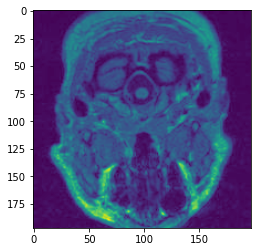

In [189]:
plt.imshow(images_test[0,0,20:217,0:197])

In [ ]:
# import pickle
# def save_as_pickle(data,filename):
#     with open(filename, 'wb') as handle:
#         return pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# def load_pickle(filename):
#     with open(filename, 'rb') as handle:
#         return pickle.load(handle)
    
# save_as_pickle(images_train,"images_train.pickle")
# save_as_pickle(images_val,"images_val.pickle")
# save_as_pickle(images_test,"images_test.pickle")

# save_as_pickle(label_train,"label_train.pickle")
# save_as_pickle(label_val,"label_val.pickle")
# save_as_pickle(label_test,"label_test.pickle")

In [8]:
# Train U-Net segmentation network

# Class imbalance problem:
# Since there are many images with no hippocampus, we want to count these images less towards the loss

# When calculating the loss on each forward pass:
# LOSS = 0.85 * mean(loss(x_with, y_with)) + 0.15 * mean(loss(x_without, y_without))

In [ ]:
def convbatchrelu(in_channels, out_channels, sz):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, sz, padding=sz//2),
      nn.BatchNorm2d(out_channels, eps=1e-5),
      nn.ReLU(inplace=True),
      )


class convdown(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    for t in range(2):
      if t == 0:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(in_channels,
                                           out_channels,
                                           kernel_size))
      else:
        self.conv.add_module('conv_%d'%t,
                             convbatchrelu(out_channels,
                                           out_channels,
                                           kernel_size))

  def forward(self, x):
    x = self.conv[0](x)
    x = self.conv[1](x)
    return x


class downsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.down = nn.Sequential()
    self.maxpool = nn.MaxPool2d(2, 2)
    for n in range(len(nbase) - 1):
      self.down.add_module('conv_down_%d'%n,
                           convdown(nbase[n],
                                    nbase[n + 1],
                                    kernel_size))

  def forward(self, x):
    xd = []
    for n in range(len(self.down)):
      if n > 0:
        y = self.maxpool(xd[n - 1])
      else:
        y = x
      xd.append(self.down[n](y))
    return xd


class convup(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super().__init__()
    self.conv = nn.Sequential()
    self.conv.add_module('conv_0', convbatchrelu(in_channels,
                                                 out_channels,
                                                 kernel_size))
    self.conv.add_module('conv_1', convbatchrelu(out_channels,
                                                 out_channels,
                                                 kernel_size))

  def forward(self, x, y):
    #print(x.shape, y.shape)
    x = self.conv[0](x)
    x = self.conv[1](x + y)
    return x


class upsample(nn.Module):
  def __init__(self, nbase, kernel_size):
    super().__init__()
    self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')
    self.up = nn.Sequential()
    for n in range(len(nbase) - 1 , 0, -1):
      self.up.add_module('conv_up_%d'%(n - 1),
              convup(nbase[n], nbase[n - 1], kernel_size))

  def forward(self, xd):
    x = xd[-1]
    for n in range(0, len(self.up)):
      if n > 0:
        x = self.upsampling(x)
      x = self.up[n](x, xd[len(xd) - 1 - n])
    return x


class Unet(nn.Module):
  def __init__(self, nbase, nout, kernel_size):
    super(Unet, self).__init__()
    self.nbase = nbase
    self.nout = nout
    self.kernel_size = kernel_size
    self.downsample = downsample(nbase, kernel_size)
    nbaseup = nbase[1:]
    nbaseup.append(nbase[-1])
    self.upsample = upsample(nbaseup, kernel_size)
    self.output = nn.Conv2d(nbase[1], self.nout, kernel_size,
                            padding=kernel_size//2)

  def forward(self, data):
    T0 = self.downsample(data)
    T0 = self.upsample(T0)
    T0 = self.output(T0)
    return T0

  def save_model(self, filename):
    torch.save(self.state_dict(), filename)

  def load_model(self, filename, cpu=False):
    if not cpu:
      self.load_state_dict(torch.load(filename))
    else:
      self.__init__(self.nbase,
                    self.nout,
                    self.kernel_size,
                    self.concatenation)

      self.load_state_dict(torch.load(filename,
                                      map_location=torch.device('cpu')))

In [35]:
def random_rotate_and_resize(X, Y=None, scale_range=0.5, xy=(224, 224),
                             do_flip=True):
  """
  Augmentation by random rotation and resizing

  X and Y are lists or arrays of length nimg, with dims channels x Ly x Lx (channels optional)

  Parameters
  ----------
  X: ND-array, float
    list of IMAGE arrays of size [nchan x Ly x Lx] or [Ly x Lx]

  Y: ND-array, float or int (optional, default None)
    list of MASK arrays of size [nlabels x Ly x Lx] or [Ly x Lx].
    ** These labels are nearest neighbor interpolated
    ** CHANGE IF USING FLOAT LABELS

  scale_range: float (optional, default 1.0)
    Range of resizing of images for augmentation. Images are resized by
    (1-scale_range/2) + scale_range * np.random.rand()

  xy: tuple, int (optional, default (224,224))
    size of transformed images to return

  do_flip: bool (optional, default True)
    whether or not to flip images horizontally

  Returns
  -------
  imgi: ND-array, float
    transformed images in array [nimg x nchan x xy[0] x xy[1]]

  lbl: ND-array, float
    transformed labels in array [nimg x nchan x xy[0] x xy[1]]

  scale: array, float
    amount each image was resized by
  """

  scale_range = max(0, min(2, float(scale_range)))
  nimg = len(X)
  if X[0].ndim > 2:
    nchan = X[0].shape[0]
  else:
    nchan = 1
  imgi  = np.zeros((nimg, nchan, xy[0], xy[1]), np.float32)

  lbl = []
  if Y is not None:
    if Y[0].ndim > 2:
      nt = Y[0].shape[0]
    else:
      nt = 1
    lbl = np.zeros((nimg, nt, xy[0], xy[1]), Y.dtype)

  scale = np.zeros(nimg, np.float32)
  for n in range(nimg):
    Ly, Lx = X[n].shape[-2:]

    # generate random augmentation parameters
    flip = np.random.rand() > .5
    theta = np.random.rand() * np.pi * 2
    scale[n] = (1 - scale_range / 2) + scale_range * np.random.rand()
    dxy = np.maximum(0, np.array([Lx*scale[n] - xy[1], Ly * scale[n] - xy[0]]))
    dxy = (np.random.rand(2,) - .5) * dxy

    # create affine transform
    cc = np.array([Lx / 2, Ly / 2])
    cc1 = cc - np.array([Lx - xy[1], Ly - xy[0]]) / 2 + dxy
    pts1 = np.float32([cc, cc + np.array([1, 0]), cc + np.array([0, 1])])
    pts2 = np.float32([cc1,
            cc1 + scale[n]*np.array([np.cos(theta), np.sin(theta)]),
            cc1 + scale[n]*np.array([np.cos(np.pi/2 + theta),
                                     np.sin(np.pi/2 + theta)])])

    M = cv2.getAffineTransform(pts1, pts2)

    img = X[n].copy()
    if Y is not None:
      labels = Y[n].copy()
      if labels.ndim < 3:
        labels = labels[np.newaxis, :, :]

    if flip and do_flip:
      img = img[..., ::-1]
      if Y is not None:
        labels = labels[..., ::-1]

    for k in range(nchan):
      I = cv2.warpAffine(img[k], M, (xy[1], xy[0]), flags=cv2.INTER_LINEAR)
      imgi[n,k] = I

    if Y is not None:
      for k in range(nt):
        # ** nearest neighbor interpolation **
        # may need to change for float labels
        lbl[n,k] = cv2.warpAffine(labels[k], M, (xy[1],xy[0]),
                                  flags=cv2.INTER_NEAREST)

  return imgi, lbl, scale

In [36]:
kernel_size = 3
nbase = [1, 32, 64, 128, 256]  # number of channels per layer
nout = 2  # number of outputs

net = Unet(nbase, nout, kernel_size)
# put on GPU here if you have it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device);  # remove semi-colon to see net structure

In [39]:
from datetime import datetime

# train the network
# parameters related to training the network
batch_size = 8 # number of images per batch -- amount of required memory
              # for training will increase linearly in batchsize
### you will want to increase n_epochs!
n_epochs = 50  # number of times to cycle through all the data during training
learning_rate = 0.1 # initial learning rate
weight_decay = 1e-5 # L2 regularization of weights
momentum = 0.9 # how much to use previous gradient direction
n_epochs_per_save = 25 # how often to save the network
val_frac = 0.05 # what fraction of data to use for validation
augmentation = True


# where to save the network
# make sure to clean these out every now and then, as you will run out of space
now = datetime.now()
timestamp = now.strftime('%Y%m%dT%H%M%S')

n_train = images_train.shape[0]
n_val = images_val.shape[0]

# gradient descent flavor
optimizer = torch.optim.SGD(net.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay,
                            momentum=0.9)

# set learning rate schedule
LR = np.linspace(0, learning_rate, 10)
if n_epochs > 250:
    LR = np.append(LR, learning_rate*np.ones(n_epochs-100))
    for i in range(10):
        LR = np.append(LR, LR[-1]/2 * np.ones(10))
else:
    LR = np.append(LR, learning_rate * np.ones(max(0, n_epochs - 10)))

criterion = nn.CrossEntropyLoss()

# store loss per epoch
epoch_losses = np.zeros(n_epochs)
epoch_losses[:] = np.nan

# when we last saved the network
saveepoch = None

# loop through entire training data set nepochs times
for epoch in range(n_epochs):
  net.train() # put in train mode (affects batchnorm)
  epoch_loss = 0
  iters = 0
  for param_group in optimizer.param_groups:
    param_group['lr'] = LR[epoch]
  with tqdm.tqdm(total=n_train, desc=f"Epoch {epoch + 1}/{n_epochs}", unit='img') as pbar:
    # loop through each batch in the training data
    for ibatch in np.arange(0, n_train, batch_size):
      # augment the data
      inds = np.arange(ibatch, min(n_train, ibatch+batch_size))
      if augmentation == True:
        imgs, lbls, _ = random_rotate_and_resize(images_train[inds],label_train[inds].astype(int))
      else: 
        imgs = images_train[inds]
        lbls = label_train[inds].astype(int)

      # transfer to torch + GPU
      imgs = torch.from_numpy(imgs).to(device=device)
      lbls = torch.from_numpy(lbls).to(device=device)

      imgs = imgs.to(dtype=torch.float32)
      lbls = lbls.to(dtype=torch.int64)

      # compute the loss
      y = net(imgs)
        
      loss = criterion(y, lbls[:, 0])
    
      epoch_loss += loss.item()
      pbar.set_postfix(**{'loss (batch)': loss.item()})
      # gradient descent
      optimizer.zero_grad()
      loss.backward()
      #nn.utils.clip_grad_value_(net.parameters(), 0.1)
      optimizer.step()
      iters+=1
      pbar.update(imgs.shape[0])

    epoch_losses[epoch] = epoch_loss
    pbar.set_postfix(**{'loss (epoch)': epoch_loss})  #.update('loss (epoch) = %f'%epoch_loss)

  # save checkpoint networks every now and then
  if epoch % n_epochs_per_save == 0:
    print(f"\nSaving network state at epoch {epoch+1}")
    saveepoch = epoch
    savefile = f"unet_epoch{saveepoch+1}.pth"
    net.save_model(savefile)
print(f"\nSaving network state at epoch {epoch+1}")
net.save_model(f"unet_epoch{epoch+1}.pth")

Epoch 1/50:   0%|          | 0/15085 [00:00<?, ?img/s]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   0%|          | 8/15085 [00:13<6:52:40,  1.64s/img, loss (batch)=0.897]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   0%|          | 16/15085 [00:26<6:51:48,  1.64s/img, loss (batch)=0.901]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   0%|          | 24/15085 [00:38<6:43:52,  1.61s/img, loss (batch)=0.893]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   0%|          | 32/15085 [00:51<6:41:50,  1.60s/img, loss (batch)=0.896]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   0%|          | 40/15085 [01:03<6:40:18,  1.60s/img, loss (batch)=0.895]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   0%|          | 48/15085 [01:16<6:37:59,  1.59s/img, loss (batch)=0.884]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   0%|          | 56/15085 [01:29<6:38:41,  1.59s/img, loss (batch)=0.886]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   0%|          | 64/15085 [01:42<6:40:15,  1.60s/img, loss (batch)=0.891]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   0%|          | 72/15085 [01:54<6:36:52,  1.59s/img, loss (batch)=0.898]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 80/15085 [02:07<6:39:07,  1.60s/img, loss (batch)=0.897]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 88/15085 [02:19<6:33:07,  1.57s/img, loss (batch)=0.881]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 96/15085 [02:31<6:29:23,  1.56s/img, loss (batch)=0.887]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 104/15085 [02:44<6:26:11,  1.55s/img, loss (batch)=0.89]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 112/15085 [02:56<6:23:52,  1.54s/img, loss (batch)=0.901]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 120/15085 [03:08<6:25:44,  1.55s/img, loss (batch)=0.901]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 128/15085 [03:21<6:30:00,  1.56s/img, loss (batch)=0.893]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 136/15085 [03:34<6:29:11,  1.56s/img, loss (batch)=0.897]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 144/15085 [03:46<6:31:17,  1.57s/img, loss (batch)=0.896]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 152/15085 [03:59<6:32:03,  1.58s/img, loss (batch)=0.896]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 160/15085 [04:12<6:40:31,  1.61s/img, loss (batch)=0.898]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 168/15085 [04:26<6:46:41,  1.64s/img, loss (batch)=0.887]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 176/15085 [04:39<6:41:57,  1.62s/img, loss (batch)=0.898]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|          | 184/15085 [04:51<6:36:19,  1.60s/img, loss (batch)=0.897]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|▏         | 192/15085 [05:03<6:32:55,  1.58s/img, loss (batch)=0.902]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|▏         | 200/15085 [05:16<6:31:41,  1.58s/img, loss (batch)=0.898]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|▏         | 208/15085 [05:28<6:28:20,  1.57s/img, loss (batch)=0.894]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|▏         | 216/15085 [05:41<6:33:10,  1.59s/img, loss (batch)=0.888]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   1%|▏         | 224/15085 [05:54<6:30:57,  1.58s/img, loss (batch)=0.895]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 232/15085 [06:06<6:28:19,  1.57s/img, loss (batch)=0.89] 

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 240/15085 [06:18<6:25:16,  1.56s/img, loss (batch)=0.897]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 248/15085 [06:31<6:25:32,  1.56s/img, loss (batch)=0.898]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 256/15085 [06:43<6:25:25,  1.56s/img, loss (batch)=0.893]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 264/15085 [06:56<6:26:30,  1.56s/img, loss (batch)=0.9]  

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 272/15085 [07:08<6:25:38,  1.56s/img, loss (batch)=0.895]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 280/15085 [07:21<6:29:41,  1.58s/img, loss (batch)=0.88] 

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 288/15085 [07:34<6:31:12,  1.59s/img, loss (batch)=0.9] 

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 296/15085 [07:47<6:33:14,  1.60s/img, loss (batch)=0.886]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 304/15085 [08:00<6:35:10,  1.60s/img, loss (batch)=0.896]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 312/15085 [08:13<6:33:38,  1.60s/img, loss (batch)=0.891]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 320/15085 [08:26<6:38:05,  1.62s/img, loss (batch)=0.886]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 328/15085 [08:39<6:39:24,  1.62s/img, loss (batch)=0.882]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 336/15085 [08:53<6:42:11,  1.64s/img, loss (batch)=0.867]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 344/15085 [09:05<6:39:22,  1.63s/img, loss (batch)=0.892]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 352/15085 [09:18<6:38:17,  1.62s/img, loss (batch)=0.897]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 360/15085 [09:31<6:37:20,  1.62s/img, loss (batch)=0.9]  

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 368/15085 [09:43<6:29:45,  1.59s/img, loss (batch)=0.888]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   2%|▏         | 376/15085 [09:56<6:24:30,  1.57s/img, loss (batch)=0.902]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 384/15085 [10:08<6:22:04,  1.56s/img, loss (batch)=0.896]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 392/15085 [10:20<6:18:56,  1.55s/img, loss (batch)=0.897]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 400/15085 [10:33<6:20:44,  1.56s/img, loss (batch)=0.905]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 408/15085 [10:45<6:24:44,  1.57s/img, loss (batch)=0.891]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 416/15085 [10:58<6:24:05,  1.57s/img, loss (batch)=0.866]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 424/15085 [11:11<6:23:38,  1.57s/img, loss (batch)=0.904]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 432/15085 [11:23<6:23:48,  1.57s/img, loss (batch)=0.89] 

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 440/15085 [11:36<6:26:01,  1.58s/img, loss (batch)=0.879]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 448/15085 [11:49<6:29:02,  1.59s/img, loss (batch)=0.892]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 456/15085 [12:01<6:25:19,  1.58s/img, loss (batch)=0.893]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 464/15085 [12:14<6:20:52,  1.56s/img, loss (batch)=0.892]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 472/15085 [12:26<6:18:40,  1.55s/img, loss (batch)=0.898]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 480/15085 [12:38<6:19:22,  1.56s/img, loss (batch)=0.895]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 488/15085 [12:51<6:16:41,  1.55s/img, loss (batch)=0.898]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 496/15085 [13:04<6:21:27,  1.57s/img, loss (batch)=0.9]  

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])
torch.Size([8, 128, 112, 112]) torch.Size([8, 64, 112, 112])
torch.Size([8, 64, 224, 224]) torch.Size([8, 32, 224, 224])


Epoch 1/50:   3%|▎         | 504/15085 [13:16<6:19:51,  1.56s/img, loss (batch)=0.897]

torch.Size([8, 256, 28, 28]) torch.Size([8, 256, 28, 28])
torch.Size([8, 256, 56, 56]) torch.Size([8, 128, 56, 56])


Epoch 1/50:   3%|▎         | 504/15085 [13:18<6:25:04,  1.58s/img, loss (batch)=0.897]


KeyboardInterrupt: 

In [ ]:
# Every epoch: compute validation loss & store it

# plot the training loss and the validation loss over epochs


## Model architecture (u-net)

A u-net is commonly used for biological image segmentation because its shape allows for local and global features to be combined to create highly-precise segmentations.

A u-net is shaped like an autoencoder, it has:
1. a standard convolutional network with downsampling, like one used for imagenet
2. upsampling layers that ultimately return an image at the same size as the input image
In addition to these downsampling and upsampling blocks, it has skip connections from the downsampling blocks TO the upsampling blocks, which allows it to propagate more precise local information to the later layers.

adapted from [cellpose/resnet_torch.py](https://github.com/MouseLand/cellpose/blob/master/cellpose/resnet_torch.py).


### Define the network

### Train the network

Here we've implemented code to train the network.

Note we probably should be evaluating test performance throughout training -- implement that yourself.

### Test performance

Let's see how the network performs on a test image.

In [40]:
# @markdown Padding code for test images

def pad_image_ND(img0, div=16, extra=1):
  """ pad image for test-time so that its dimensions are a multiple of 16 (2D or 3D)

  Parameters
  -------------
  img0: ND-array
      image of size [nchan (x Lz) x Ly x Lx]
  div: int (optional, default 16)

  Returns
  --------------
  I: ND-array
      padded image
  slices: tuple, int
      range of pixels in I corresponding to img0
  """
  Lpad = int(div * np.ceil(img0.shape[-2] / div) - img0.shape[-2])
  xpad1 = extra * div//2 + Lpad//2
  xpad2 = extra * div//2 + Lpad - Lpad//2
  Lpad = int(div * np.ceil(img0.shape[-1] / div) - img0.shape[-1])
  ypad1 = extra * div//2 + Lpad//2
  ypad2 = extra * div//2 + Lpad - Lpad//2

  if img0.ndim > 3:
    pads = np.array([[0, 0], [0, 0], [xpad1, xpad2], [ypad1, ypad2]])
  else:
    pads = np.array([[0, 0], [xpad1, xpad2], [ypad1, ypad2]])

  I = np.pad(img0, pads, mode='constant')

  Ly, Lx = img0.shape[-2:]
  ysub = np.arange(xpad1, xpad1 + Ly)
  xsub = np.arange(ypad1, ypad1 + Lx)
  slc = [slice(0, img0.shape[n] + 1) for n in range(img0.ndim)]
  slc[-3] = slice(0, imgs.shape[-3] + 1)
  slc[-2] = slice(ysub[0], ysub[-1] + 1)
  slc[-1] = slice(xsub[0], xsub[-1] + 1)
  slc = tuple(slc)

  return I, slc

In [210]:
out.shape[]

torch.Size([1, 2, 224, 224])

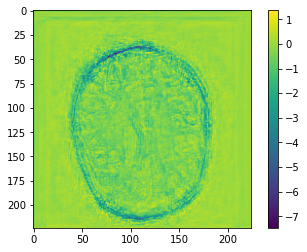

In [216]:
plt.imshow(out[0,0].detach())
plt.colorbar()

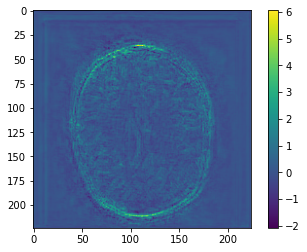

In [215]:
plt.imshow(out[0,1].detach())
plt.colorbar()

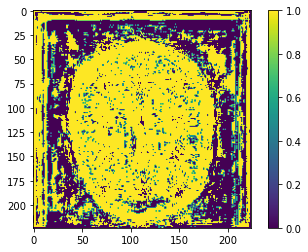

In [244]:
prediction = np.array(out[0].detach())
seg = np.argmax(prediction,axis=0)
plt.imshow(seg)
plt.colorbar()
plt.savefig('brain_segmentation.png')

torch.Size([1, 256, 28, 28]) torch.Size([1, 256, 28, 28])
torch.Size([1, 256, 56, 56]) torch.Size([1, 128, 56, 56])
torch.Size([1, 128, 112, 112]) torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 224, 224]) torch.Size([1, 32, 224, 224])


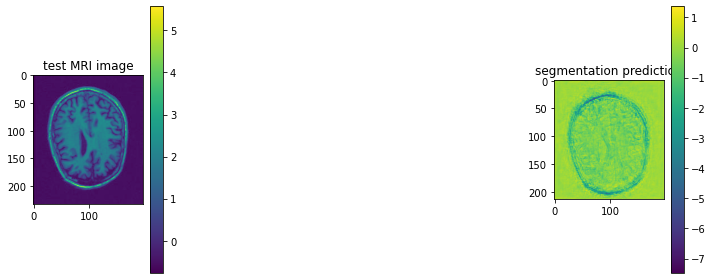

In [209]:
# compute results on test images
# (note for unet to run correctly we need to pad images to be divisible by 2**(number of layers))
image = images_train[0]

net.eval()
img_padded, slices = pad_image_ND(image, 16)
img_padded = torch.tensor(img_padded[:,0:224,0:224]).unsqueeze(0)
img_torch = img_padded.to(torch.float32)
#img_torch = torch.from_numpy(img_padded).to(device).unsqueeze(0)  # also need to add a first dimension
out = net(img_torch)
labels = out[0][slices].detach().cpu()

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(image[0])
plt.colorbar()
plt.title('test MRI image')

plt.subplot(1, 4, 4)
plt.imshow(labels[0])
plt.colorbar()
plt.title('segmentation prediction')
plt.tight_layout()
plt.show()

In [ ]:
# Test network performance & plot performance metrics

# https://scikit-learn.org/stable/modules/classes.html?highlight=metric#module-sklearn.metrics


# F-score
# accuracy

### Setting threshold for finding cells

We have found areas of "not cell" and "cell". To create an instance segmentation we need to assign each pixel in a cell to a specific cell rather than a general class. To do this, we will need to find a threshold that produces the best segmentations on our validation set. How do we define a good segmentation? We can use a measure called intersection-over-union (IoU) and call a cell a good cell if it overlaps with a ground-truth cell with an IoU greater than some value. We have taken code from [cellpose/metrics.py] to do this. These functions are based on functions from [stardist], another neat algorithm I recommend checking out!

This code below computes the average precision (which you want to maximize) for a given threshold. You'll want to try several thresholds and choose one (probably coding up a loop over reasonable thresholds).

In [159]:
# @title Helper functions

# @markdown `fill_holes_and_remove_small_masks` function
def fill_holes_and_remove_small_masks(masks, min_size=15):
  """ fill holes in masks (2D/3D) and discard masks smaller than min_size (2D)

  fill holes in each mask using scipy.ndimage.morphology.binary_fill_holes

  Parameters
  ----------------
  masks: int, 2D or 3D array
      labelled masks, 0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  min_size: int (optional, default 15)
      minimum number of pixels per mask, can turn off with -1

  Returns
  ---------------
  masks: int, 2D or 3D array
      masks with holes filled and masks smaller than min_size removed,
      0=NO masks; 1,2,...=mask labels,
      size [Ly x Lx] or [Lz x Ly x Lx]
  """
  slices = find_objects(masks)
  j = 0
  for i,slc in enumerate(slices):
    if slc is not None:
      msk = masks[slc] == (i + 1)
      npix = msk.sum()
      if min_size > 0 and npix < min_size:
        masks[slc][msk] = 0
      else:
        if msk.ndim==3:
          for k in range(msk.shape[0]):
            msk[k] = binary_fill_holes(msk[k])
        else:
          msk = binary_fill_holes(msk)
        masks[slc][msk] = (j + 1)
        j += 1

  return masks


# @markdown `average_precision` function
def average_precision(masks_true, masks_pred, threshold=[0.5, 0.75, 0.9]):
  """ average precision estimation: AP = TP / (TP + FP + FN)

  This function is based heavily on the *fast* stardist matching functions
  (https://github.com/mpicbg-csbd/stardist/blob/master/stardist/matching.py)

  Parameters
  ------------
  masks_true: list of ND-arrays (int)
      where 0=NO masks; 1,2... are mask labels
  masks_pred: list of ND-arrays (int)
      ND-array (int) where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  ap: array [len(masks_true) x len(threshold)]
      average precision at thresholds
  tp: array [len(masks_true) x len(threshold)]
      number of true positives at thresholds
  fp: array [len(masks_true) x len(threshold)]
      number of false positives at thresholds
  fn: array [len(masks_true) x len(threshold)]
      number of false negatives at thresholds
  """
  if not isinstance(threshold, list) and not isinstance(threshold, np.ndarray):
    threshold = [threshold]
  ap  = np.zeros((len(masks_true), len(threshold)), np.float32)
  tp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fp  = np.zeros((len(masks_true), len(threshold)), np.float32)
  fn  = np.zeros((len(masks_true), len(threshold)), np.float32)
  n_true = np.array(list(map(np.max, masks_true)))
  n_pred = np.array(list(map(np.max, masks_pred)))
  for n in range(len(masks_true)):
    #_,mt = np.reshape(np.unique(masks_true[n], return_index=True), masks_pred[n].shape)
    if n_pred[n] > 0:
      iou = _intersection_over_union(masks_true[n], masks_pred[n])[1:, 1:]
      for k,th in enumerate(threshold):
        tp[n,k] = _true_positive(iou, th)
    fp[n] = n_pred[n] - tp[n]
    fn[n] = n_true[n] - tp[n]
    ap[n] = tp[n] / (tp[n] + fp[n] + fn[n])

  return ap, tp, fp, fn


@jit(nopython=True)
def _label_overlap(x, y):
  """ fast function to get pixel overlaps between masks in x and y

  Parameters
  ------------
  x: ND-array, int
      where 0=NO masks; 1,2... are mask labels
  y: ND-array, int
      where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  overlap: ND-array, int
      matrix of pixel overlaps of size [x.max()+1, y.max()+1]
  """
  x = x.ravel()
  y = y.ravel()
  overlap = np.zeros((1 + x.max(), 1 + y.max()), dtype=np.uint)
  for i in range(len(x)):
    overlap[x[i], y[i]] += 1

  return overlap


def _intersection_over_union(masks_true, masks_pred):
  """ intersection over union of all mask pairs

  Parameters
  ------------
  masks_true: ND-array, int
      ground truth masks, where 0=NO masks; 1,2... are mask labels
  masks_pred: ND-array, int
      predicted masks, where 0=NO masks; 1,2... are mask labels

  Returns
  ------------
  iou: ND-array, float
      matrix of IOU pairs of size [x.max()+1, y.max()+1]
  """
  overlap = _label_overlap(masks_true, masks_pred)
  n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
  n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
  iou = overlap / (n_pixels_pred + n_pixels_true - overlap)
  iou[np.isnan(iou)] = 0.0

  return iou


def _true_positive(iou, th):
  """ true positive at threshold th

  Parameters
  ------------
  iou: float, ND-array
      array of IOU pairs
  th: float
      threshold on IOU for positive label

  Returns
  ------------
  tp: float
      number of true positives at threshold
  """
  n_min = min(iou.shape[0], iou.shape[1])
  costs = -(iou >= th).astype(float) - iou / (2 * n_min)
  true_ind, pred_ind = linear_sum_assignment(costs)
  match_ok = iou[true_ind, pred_ind] >= th
  tp = match_ok.sum()

  return tp

In [178]:
images_test[0].shape

(1, 233, 197)

In [172]:
out[slices].shape

torch.Size([10, 2, 213, 197])

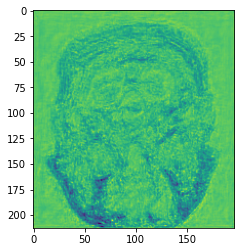

In [176]:
plt.imshow(out[slices][0,0].detach())

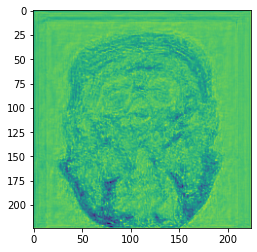

In [177]:
plt.imshow(out[0,0].detach())

In [ ]:
labels = out[slices].detach().cpu().numpy()


0.5039152


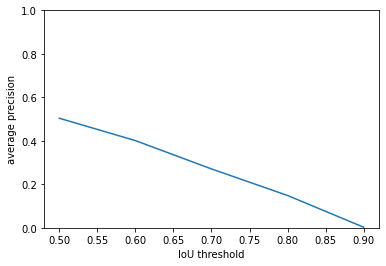

In [ ]:
def get_masks_unet(output, cell_threshold=0, min_size=30):
  """ create masks using NOT CELL probability and CELL probability

  min_size: minimum number of pixels in the masks
  """

  cells = (output[1] - output[0]) > cell_threshold
  selem = generate_binary_structure(cells.ndim, connectivity=1)
  masks, nlabels = label(cells, selem)
  shape0 = masks.shape
  _,masks = np.unique(masks, return_inverse=True)
  masks = np.reshape(masks, shape0)
  # fill holes and remove small masks
  masks = fill_holes_and_remove_small_masks(masks, min_size=min_size)

  return masks.astype(np.uint16)


# images_test 
# label_test

image = images_train[0]

# net.eval()
# img_padded, slices = pad_image_ND(image, 16)
# img_padded = torch.tensor(img_padded[:,0:224,0:224]).unsqueeze(0)
# img_torch = img_padded.to(torch.float32)
# #img_torch = torch.from_numpy(img_padded).to(device).unsqueeze(0)  # also need to add a first dimension
# out = net(img_torch)
# labels = out[0][slices].detach().cpu()



# Run the model
net.eval()
# (depending on GPU capacity you may need to run this in a loop)

test_padded, slices = pad_image_ND(images_test, 16)
test_padded = torch.tensor(test_padded[:,:,0:224,0:224])
test_padded = test_padded.to(torch.float32)
#val_torch = torch.from_numpy(val_padded).to(device)
out = net(test_padded)

# compute CELL / NOT CELL probability
labels = out[slices].detach().cpu().numpy()

# create masks from probabilities
cell_threshold = 2.5
masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]

# (note this function expects multiple masks)
iou_threshold = np.arange(0.5, 1, 0.1)
ap = average_precision(val_masks, masks, threshold=iou_threshold)[0]

# plot results
print(ap[:, 0].mean(axis=0))
plt.plot(iou_threshold, ap.mean(axis=0))
plt.xlabel('IoU threshold')
plt.ylabel('average precision')
plt.ylim([0, 1])
plt.show()

Once you choose a threshold, you'll want to use it on your test images.

0.58384985


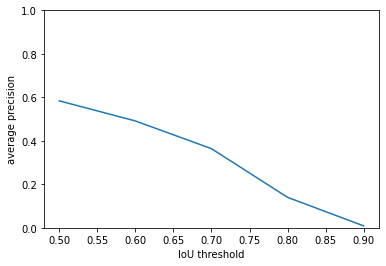

In [ ]:
net.eval()
# (depending on GPU capacity you may need to run this in a loop)
test_padded, slices = pad_image_ND(imgs_test, 8)
test_torch = torch.from_numpy(test_padded).to(device)
out = net(test_torch)
# compute CELL / NOT CELL probability
labels = out[slices].detach().cpu().numpy()

# create masks from probabilities
masks = [get_masks_unet(lbl, cell_threshold=cell_threshold) for lbl in labels]

# (note this function expects multiple masks)
iou_threshold = np.arange(0.5, 1, 0.1)
ap = average_precision(masks_test, masks, threshold=iou_threshold)[0]

# plot results
print(ap[:,0].mean(axis=0))
plt.plot(iou_threshold, ap.mean(axis=0))
plt.xlabel('IoU threshold')
plt.ylabel('average precision')
plt.ylim([0, 1])
plt.show()

What kinds of errors is the network making?

U-nets with this type of prediction (CELL/NOT CELL) typically overmerge cells. You may see some examples below. In the text at the beginning, ways to avoid this problem are discussed and also one instance (distance to boundary) is implemented in the cellpose repository. 

You can also compare your results to cellpose using the web interface at [www.cellpose.org](https://www.cellpose.org).

Below you can see that we are plotting the ground truth masks (the true masks) and the masks that the algorithm predicted. It may be sort of hard to compare the masks in a jupyter-notebook. One useful tool to visualize imaging data is [napari](https://www.napari.org). You can try running it on your local computer and visualizing your predictions overlaid on the original images.

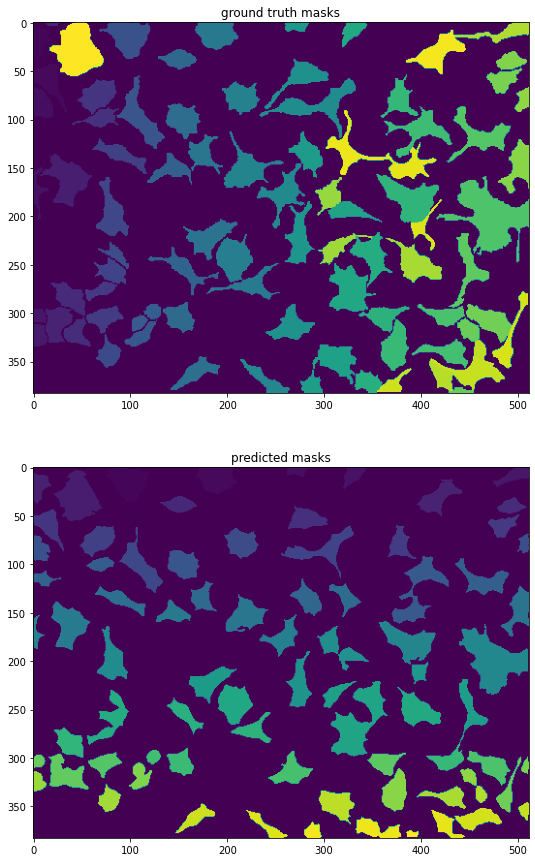

In [ ]:
plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
plt.imshow(masks_test[0])
plt.title('ground truth masks')
plt.subplot(2, 1, 2)
plt.imshow(masks[0])
plt.title('predicted masks')
plt.show()